<a href="https://colab.research.google.com/github/macereo/ds-portfolio/blob/main/predicting_insurance_costs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
import matplotlib.pyplot as plt

In [2]:
# Setting a general theme for cleanliness, will be adjusting on specific plots as necessary
sns.set_theme(style = 'darkgrid')
palette = sns.set_palette('icefire')

In [3]:
# Let's read in our insurance data and get to know the dataset
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
data.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [5]:
data.info(), data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


(None, (1338, 7))

In [6]:
data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [7]:
# No nulls is always exciting

# Because I will be encoding, I want to determine the best type of encoder to make sure my dataset remains an approrpiate size for computing

# Here I'm looking at how many unique values are each each column to see how my dimensionality will increase based on the encoder I use - none of these are super extravigant, so I should be good. (This is mainly due to simple computing constraints, I don't want to be constantly crashing my RAM.)

# I won't be encoding my target 'charges', so having 1337 unique charges is fine.
data['age'].nunique(), data['sex'].nunique(), data['bmi'].nunique(), data['children'].nunique(), data['smoker'].nunique(), data['region'].nunique(), data['charges'].nunique()

(47, 2, 548, 6, 2, 4, 1337)

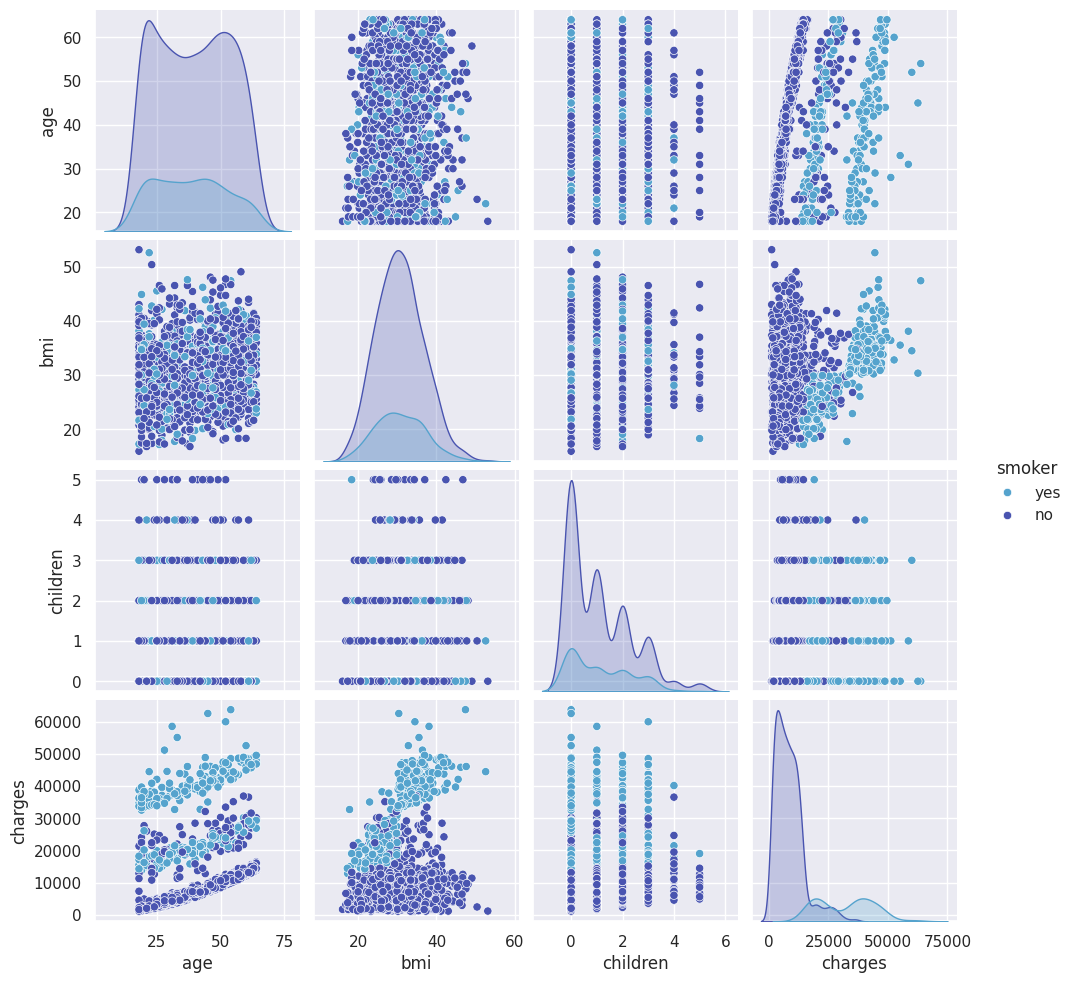

In [8]:
# There are no nulls, so I don't need to handle missing values.

# Let's take a look at a pairplot for a good overview of the data. I like getting a sense of where I should dig deeper if I don't know what my data looks like, and I do like interesting surprises.
sns.pairplot(data, hue = 'smoker', palette = palette)
plt.show()

In [11]:
# Some pretty interesting things to look at here, not too surprising but interesting. I'm curious about the correlation matrix, so let's get ready to visualize that.

# I need to separate my target column ('charges') from my other columns
charges_df = data['charges']

charges_df.head()

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520


In [14]:
# Now I need to separate my categorical and non-categorial columns
cat_cols = data.select_dtypes(include = ['object'])
num_cols = data.select_dtypes(exclude = ['object']).drop(columns = ['charges'])

# Chose to scale children because I don't think it will necessarily play into the cost as much as other features.

#cat_cols.head()
num_cols.head()

,age,bmi,children
0,19,27.900,0
1,18,33.770,1
2,28,33.000,3
3,33,22.705,0
4,32,28.880,0


In [15]:
# Now I need to encode my categorical features and scale my non-categorical (numeric) features

# Since I've taken a pretty good look at the data and it appears to follow a normal distribution in many places, I'll use StandardScaler for numeric features, OneHotEncoder for categorical features because they don't have any order, and Ordinal for features that have a sort-of order.

# Encoding categorical features
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)
cat_cols_encoded = pd.DataFrame(ohe.fit_transform(data[cat_cols.columns]), columns = ohe.get_feature_names_out(cat_cols.columns))

# Scaling numeric features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols_scaled = pd.DataFrame(scaler.fit_transform(data[num_cols.columns]), columns = num_cols.columns)

# Add them together to get a new dataframe with all numeric values (these are still only the features)
data_encoded = pd.concat([num_cols_scaled, cat_cols_encoded], axis = 1)

data_encoded.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


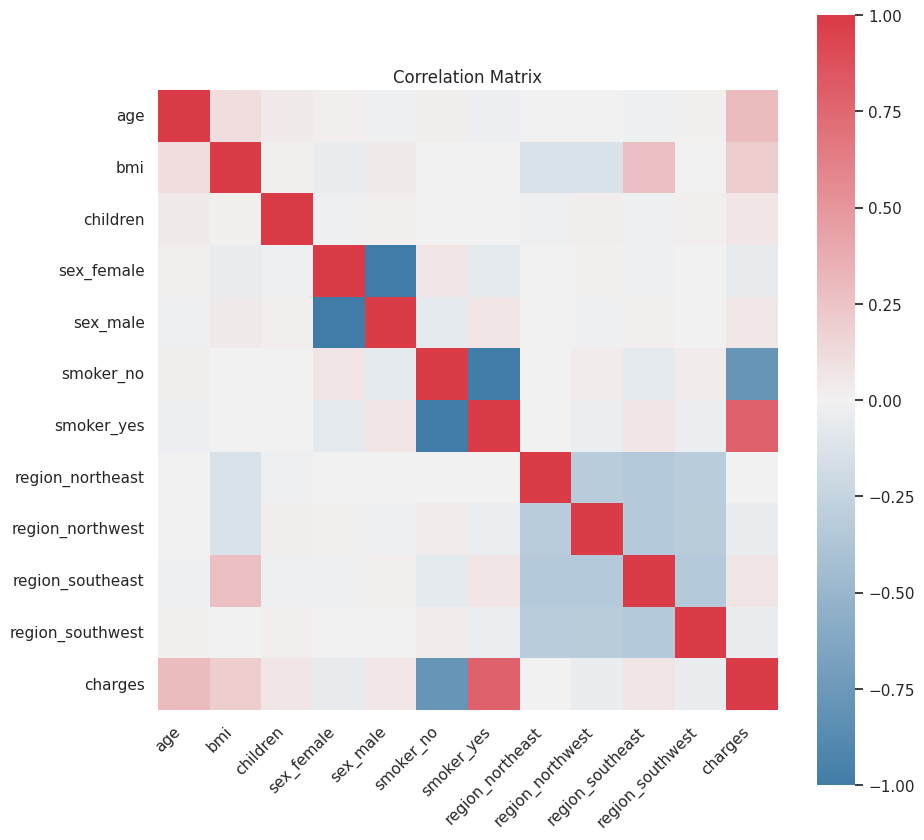

In [16]:
# Now that my data is encoded, I can do statistical operations, first with my correlation matrix, followed by some plots based on my current and previous observations.

# Since I created a separate dataframe for my features, I also need to add my target back to my dataframe, it's what I'm trying to predict.

data_encoded_charges = pd.concat([data_encoded, charges_df], axis = 1)

corr_matrix = data_encoded_charges.corr()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corr_matrix,
            mask = np.zeros_like(corr_matrix, dtype = bool),
            cmap = sns.diverging_palette(240, 10, as_cmap = True),
            square = True, ax = ax)

plt.xticks(rotation = 45, ha = 'right')

plt.title('Correlation Matrix')
plt.show()

<Figure size 2000x1500 with 0 Axes>

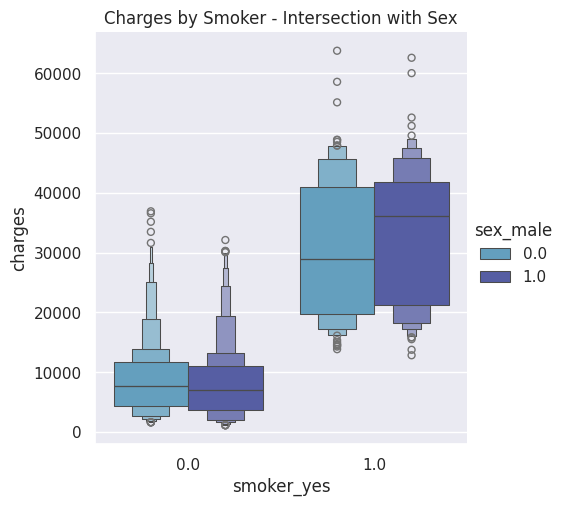

In [17]:
# Let's take a look at charges for smokers vs. non-smokers
plt.figure(figsize = (20, 15))
sns.catplot(x = 'smoker_yes', y = 'charges', kind = 'boxen', hue = 'sex_male', data = data_encoded_charges, palette = palette)
plt.title('Charges by Smoker - Intersection with Sex')
plt.show()

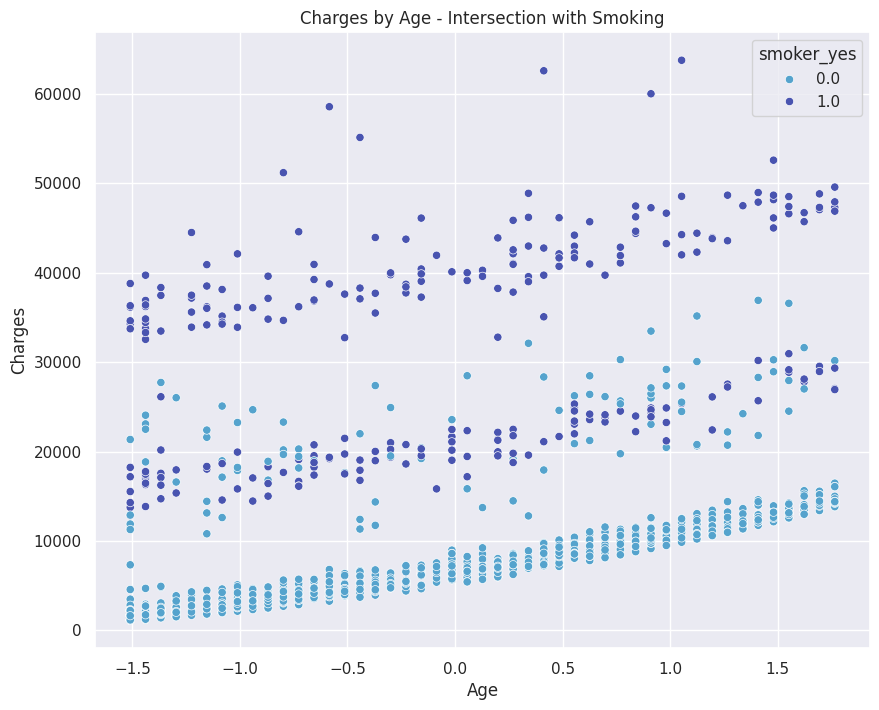

In [18]:
# Comparing ages and charges intersection with smoking
plt.figure(figsize = (10, 8))
sns.scatterplot(data = data_encoded_charges, x = 'age', y = 'charges', hue = 'smoker_yes')

plt.title('Charges by Age - Intersection with Smoking')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.show()

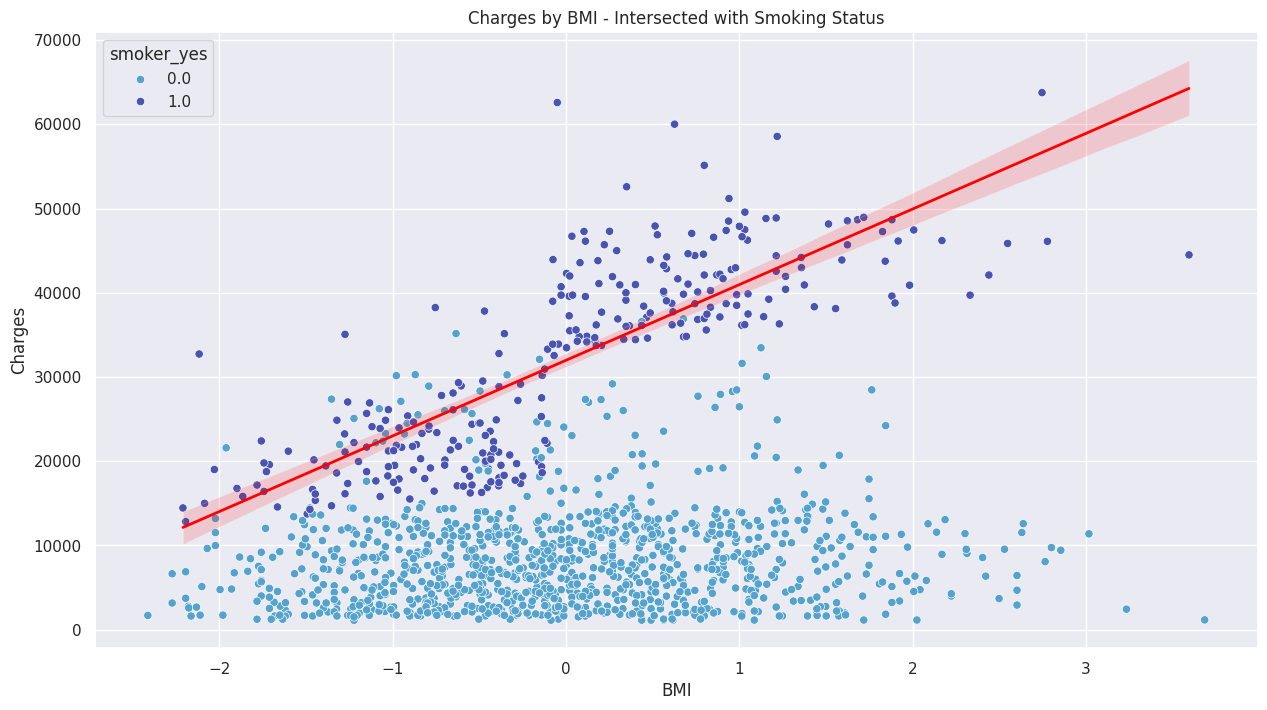

In [19]:
# Looking at BMI and charges intersected by smoking status
plt.figure(figsize = (15, 8))
sns.scatterplot(x = 'bmi',
                y = 'charges',
                hue = 'smoker_yes',
                data = data_encoded_charges,
                palette = palette)
# Adding a trend line for smokers
sns.regplot(x = 'bmi',
            y = 'charges',
            data = data_encoded_charges[data_encoded_charges['smoker_yes'] == 1],
            scatter = False,
            line_kws = {'lw':2},
            color = 'red',
            ax = plt.gca())

plt.title('Charges by BMI - Intersected with Smoking Status')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

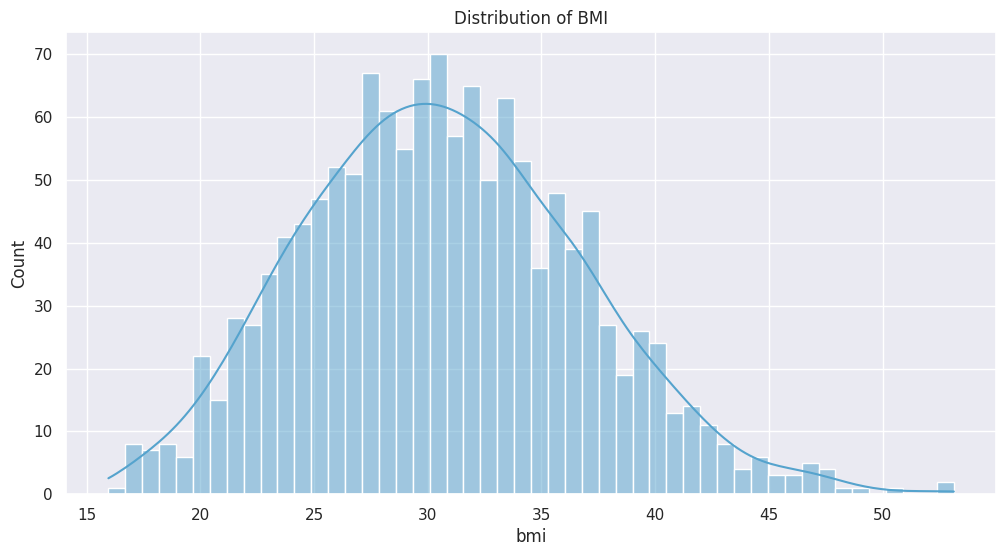

In [20]:
# I want to take a look at overall BMI distribution real quick
plt.figure(figsize = (12, 6))
plt.title('Distribution of BMI')
sns.histplot(data['bmi'], bins = 50, kde = True, color = palette)
plt.show()

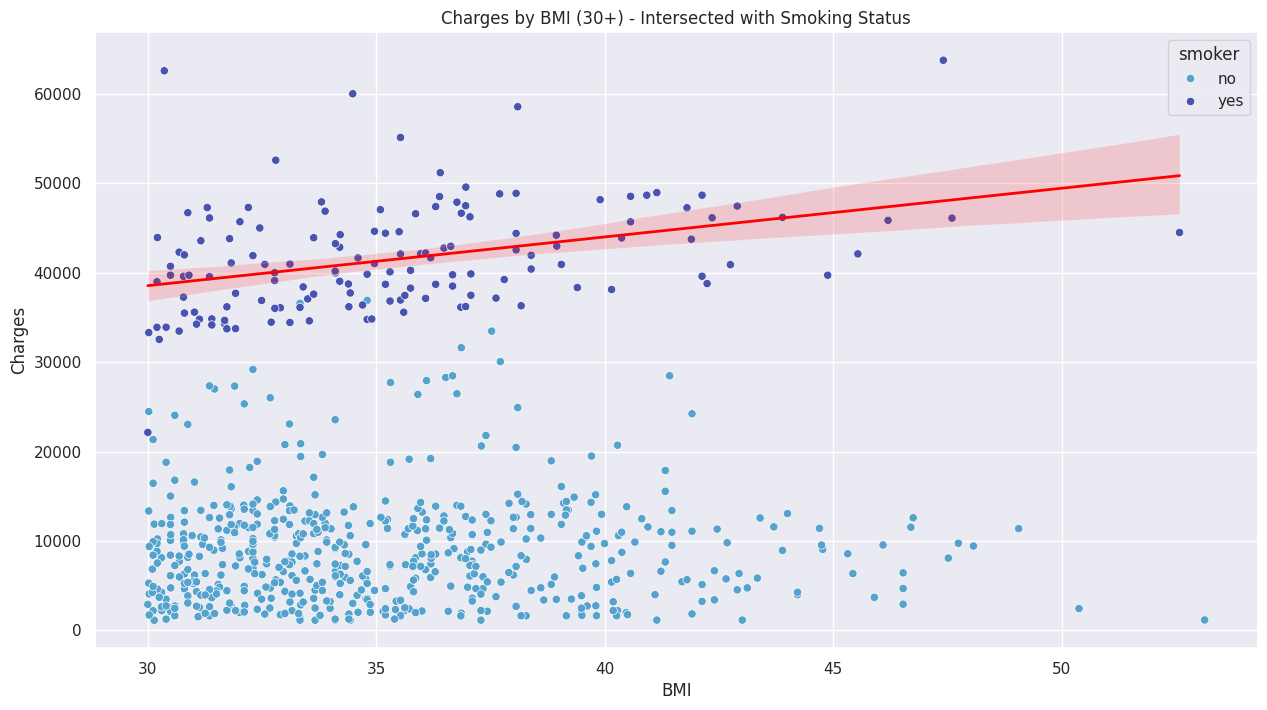

In [21]:
# Now I want to take a look at the folks with BMI of >= 30, that's where my pairplot shows a pretty big shift in charges, and further shown just above. Let's look at it a bit closer.

bmi_filtered = data[data['bmi'] >= 30].reset_index(drop = True)

# Looking at BMI and charges intersected by smoking status
plt.figure(figsize = (15, 8))
sns.scatterplot(x = 'bmi',
                y = 'charges',
                hue = 'smoker',
                data = bmi_filtered,
                palette = palette)
# Adding a trend line for smokers
sns.regplot(x = 'bmi',
            y = 'charges',
            data = bmi_filtered[bmi_filtered['smoker'] == 'yes'],
            scatter = False,
            line_kws = {'lw':2},
            color = 'red',
            ax = plt.gca())

plt.title('Charges by BMI (30+) - Intersected with Smoking Status')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.show()

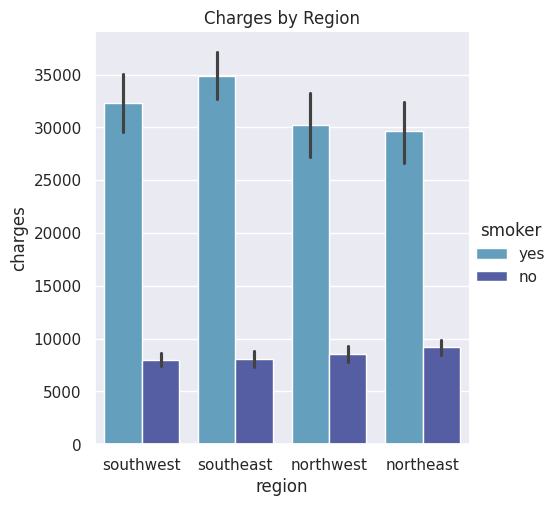

In [22]:
# Looking at charges by region and smoking status
sns.catplot(x = 'region', y = 'charges', hue = 'smoker', kind = 'bar', data = data, palette = palette)
plt.title('Charges by Region')
plt.show()

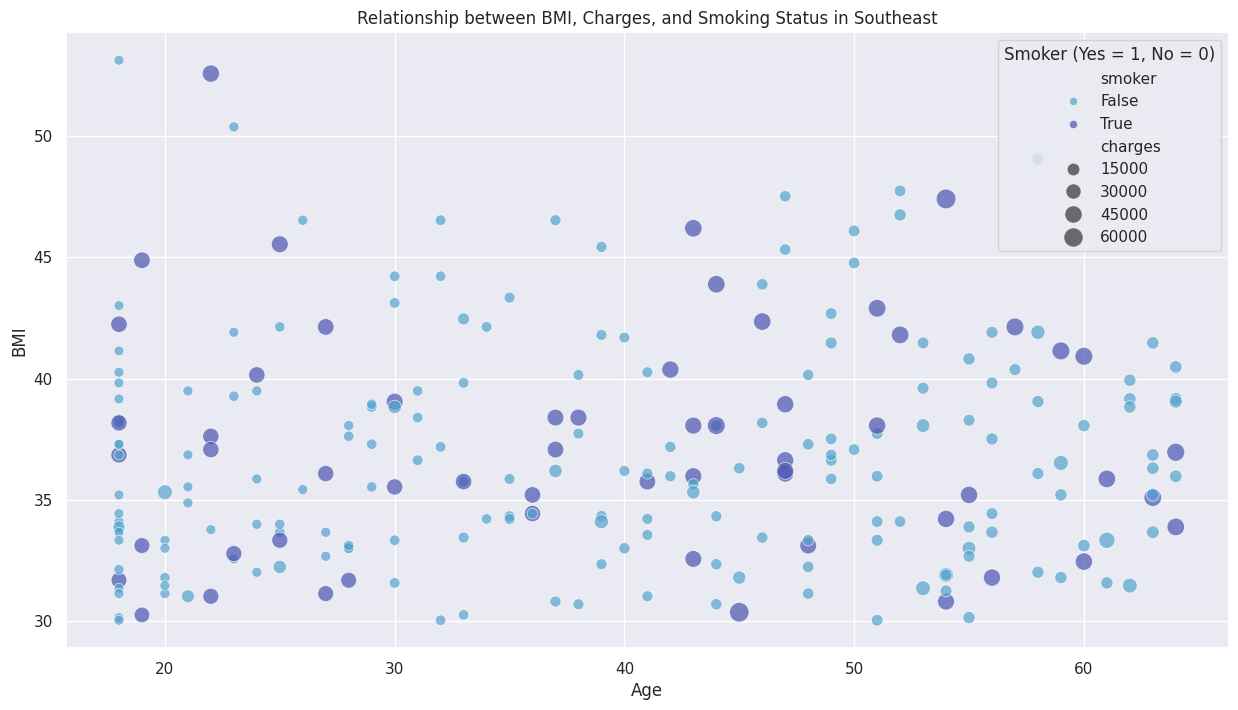

In [23]:
# Looking at the southeast region, bmi, smoking status, age

southeast_filtered = data[data['region'] == 'southeast'].reset_index(drop = True)

southeast_bmi_filtered = southeast_filtered[southeast_filtered['bmi'] >= 30].reset_index(drop = True)

plt.figure(figsize = (15, 8))
sns.scatterplot(x = 'age',
                y = 'bmi',
                size = 'charges',
                hue = southeast_bmi_filtered['smoker'] == 'yes',
                data = southeast_bmi_filtered,
                palette = palette,
                sizes = (50, 200),
                alpha = 0.7)

plt.title('Relationship between BMI, Charges, and Smoking Status in Southeast')
plt.xlabel('Age')
plt.ylabel('BMI')
plt.legend(title = 'Smoker (Yes = 1, No = 0)')
plt.show()

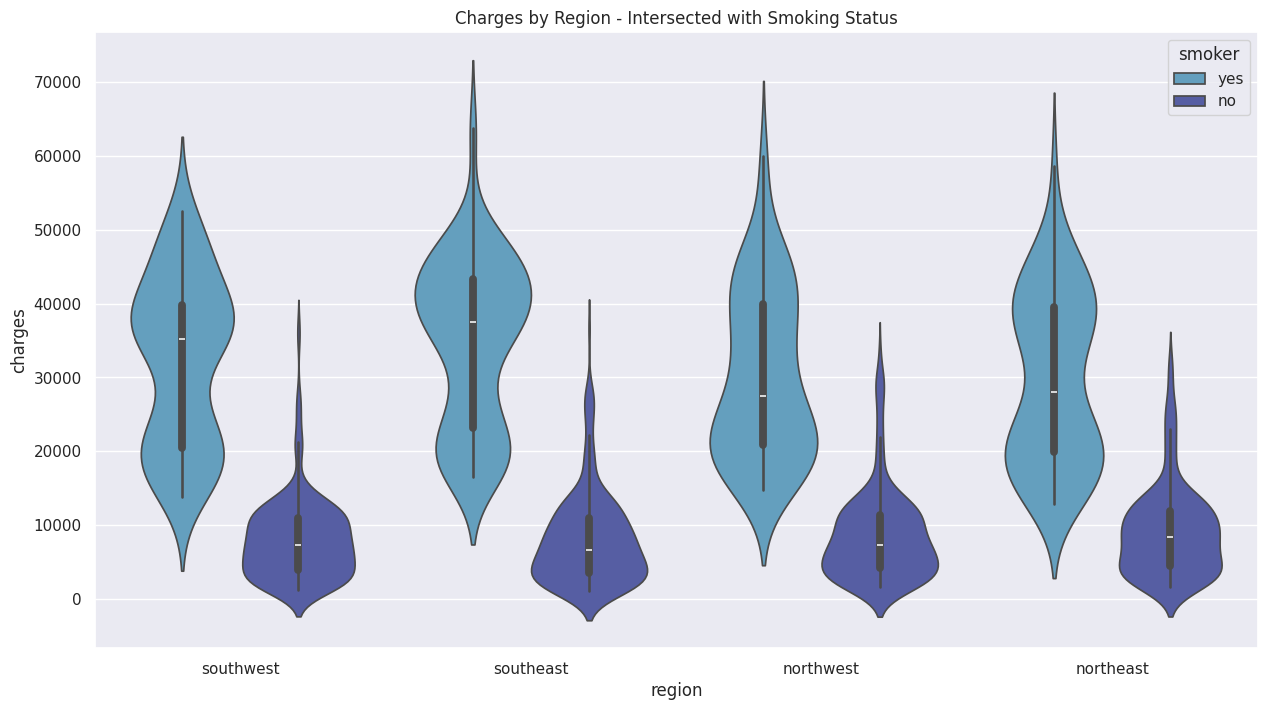

In [24]:
plt.figure(figsize = (15, 8))
sns.violinplot(x = 'region', y = 'charges', data = data, hue = 'smoker', palette = palette)
plt.title('Charges by Region - Intersected with Smoking Status')
plt.show()

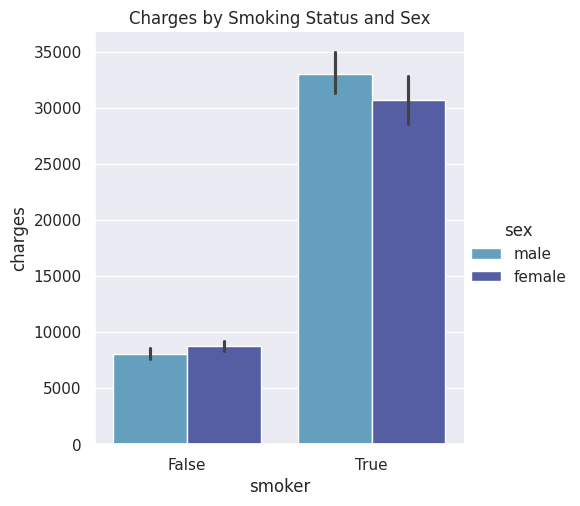

In [25]:
# Now I want to isolate some features and answer some questions about charges and sex to see if charges are impacted by sex at all
sns.catplot(x = data['smoker'] == 'yes', y = 'charges', hue = 'sex', kind = 'bar', data = data, palette = palette)
plt.title('Charges by Smoking Status and Sex')
plt.show()

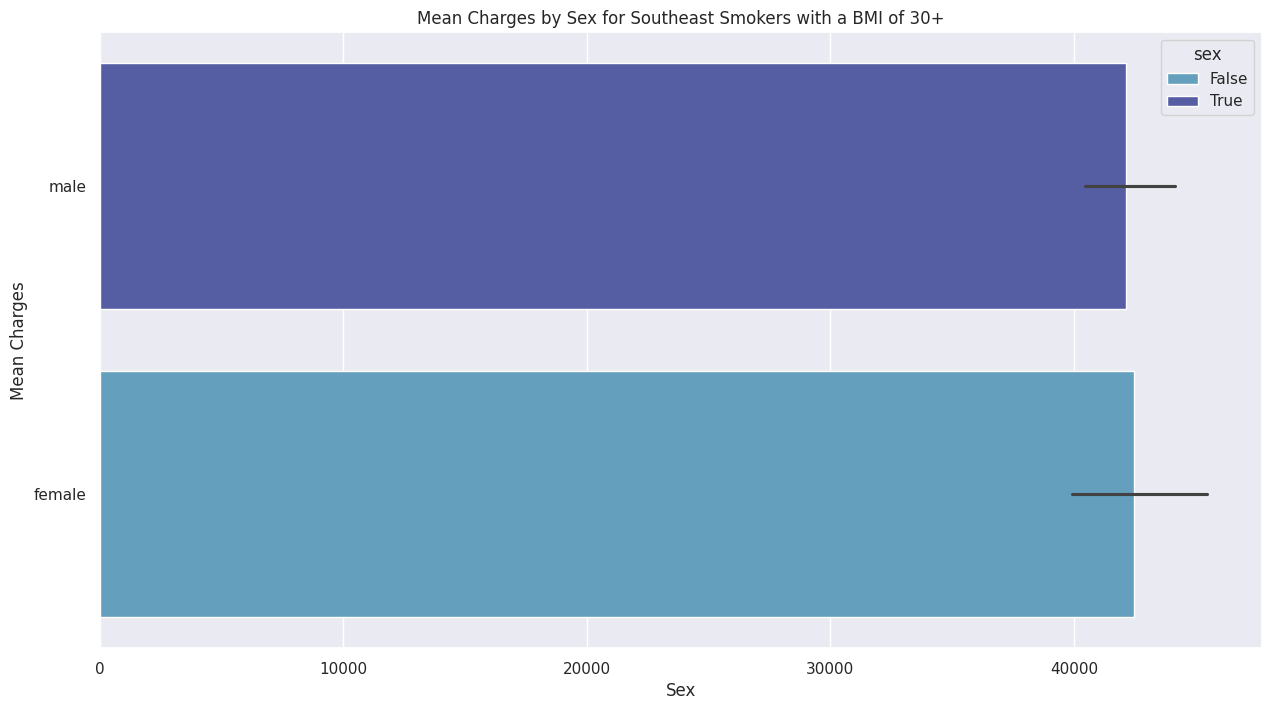

In [26]:
# Based on what we know so far, let's filter out smokers who live in the southeast region first everyone, but then with bmi of 30+, and take a look at if there is a significant difference in charges by sex

southeast_smokers = data[(data['region'] == 'southeast') & (data['smoker'] == 'yes')].reset_index(drop = True)

southeast_smokers_bmi_over30 = southeast_smokers[southeast_smokers['bmi'] >= 30].reset_index(drop = True)

plt.figure(figsize = (15, 8))
sns.barplot(x = 'charges', y = 'sex', hue = southeast_smokers_bmi_over30['sex'] == 'male', data = southeast_smokers_bmi_over30, palette = palette)
plt.title('Mean Charges by Sex for Southeast Smokers with a BMI of 30+')
plt.xlabel('Sex')
plt.ylabel('Mean Charges')
plt.show()

In [27]:
# I knew there must have been a pretty big reduction in instances for the means to be so close. That being said, let's take a closer look and see what kind of outliers there are, if any.
len(southeast_smokers_bmi_over30)

58

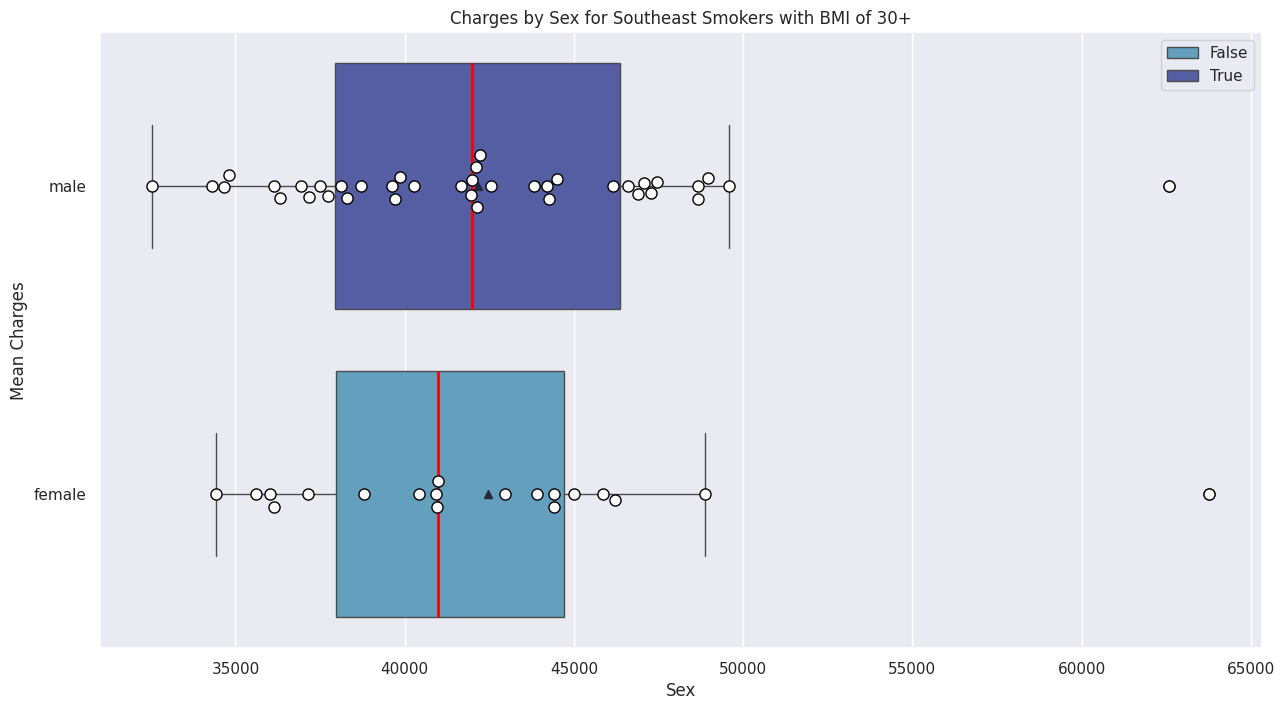

In [28]:
# These means are much more similar than I expected. Let's take a closer look.
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'charges', y = 'sex', hue = southeast_smokers_bmi_over30['sex'] == 'male', data = southeast_smokers_bmi_over30, palette = palette, showmeans = True, medianprops = {'color': 'red', 'linewidth': 2}, flierprops = {'marker': 'o', 'markerfacecolor': 'red', 'markersize': 8})
sns.swarmplot(x = 'charges', y = 'sex', data = southeast_smokers_bmi_over30, color = 'white', edgecolor = 'black', linewidth = 1, size = 8)
plt.title('Charges by Sex for Southeast Smokers with BMI of 30+')
plt.xlabel('Sex')
plt.ylabel('Mean Charges')
plt.show()

In [29]:
# I know I have some pretty significant outliers as illustrated above. I want to do a logarithmic transformation to address these and ensure they don't have a significant impact on my models.

# Transforming original 'charges' first
data['charges_log'] = np.log1p(data['charges'])

# Replace the original 'charges' with transformed 'charges' in my encoded DF
data_encoded_charges = pd.concat([data_encoded, data['charges_log']], axis = 1)

data_encoded_charges.head()

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,charges_log
0,-1.438764,-0.453320,-0.908614,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,9.734236
1,-1.509965,0.509621,-0.078767,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,7.453882
2,-0.797954,0.383307,1.580926,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,8.400763
3,-0.441948,-1.305531,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,9.998137
4,-0.513149,-0.292556,-0.908614,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,8.260455


In [32]:
# Now, I want to do a simple linear regression to establish a baseline and see how I can improve my model

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Assign X and y and separate into test/train
X = data_encoded_charges.drop(columns = ['charges_log'])
y = data_encoded_charges['charges_log']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Assign my regression model and fit to train data
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Make predictions on test set
y_pred_lin = lin_reg.predict(X_test)

# Evaluate - MAE will be in the same unit as target
mse = mean_squared_error(y_test, y_pred_lin)
mae = mean_absolute_error(y_test, y_pred_lin)
r2 = r2_score(y_test, y_pred_lin)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.17550910855320737
Mean Absolute Error: 0.26965057295320444
R-squared: 0.8047410791393023


In [35]:
# Not a bad start! Let's see if RandomForestRegression will improve the fit.

# X and y were already assigned - assign new RFR model and fit to training data
rand_for_reg = RandomForestRegressor(n_estimators = 150, max_depth = 8, min_samples_split = 3, min_samples_leaf = 2, max_features = 'sqrt', random_state = 42)
rand_for_reg.fit(X_train, y_train)

# Make predictions on test set
y_pred_rfr = rand_for_reg.predict(X_test) # Predicting in log scale

# Evaluate
mse_rfr = mean_squared_error(y_test, y_pred_rfr)
mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
r2_rfr = r2_score(y_test, y_pred_rfr)

print(f'Mean Squared Error (RFR): {mse_rfr}')
print(f'Mean Absolute Error (RFR): {mae_rfr}')
print(f'R-squared (RFR): {r2_rfr}')

Mean Squared Error (RFR): 0.1356276963191596
Mean Absolute Error (RFR): 0.2225558960056982
R-squared (RFR): 0.8491102949561555


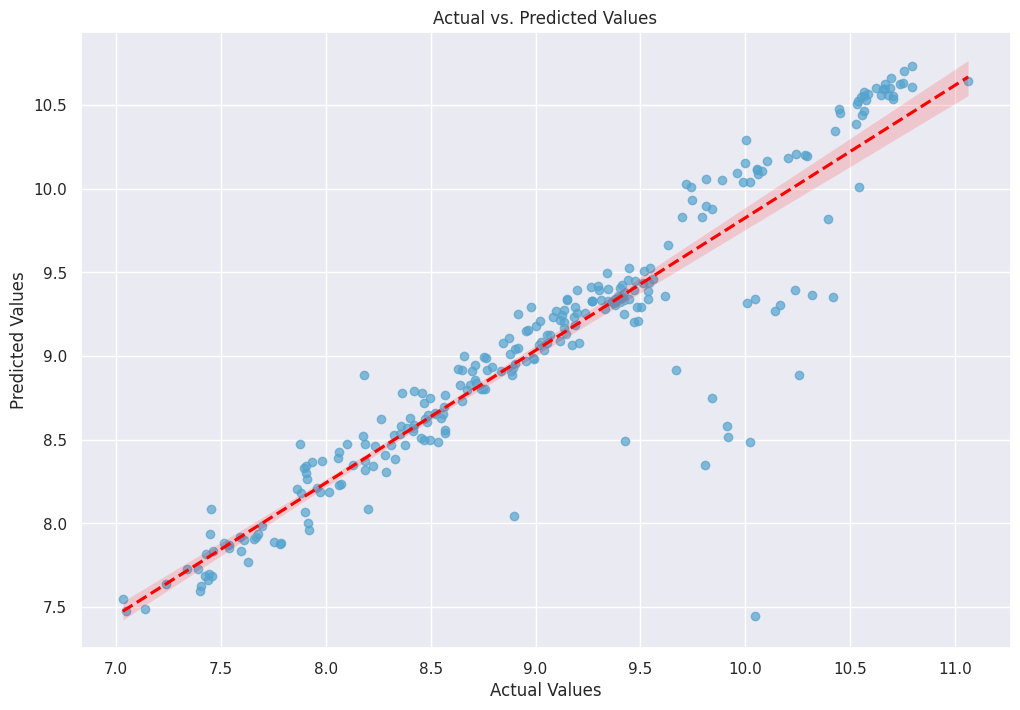

In [36]:
# Now that I'm happy with my regression results, I want to visualize them.

# Plotting actual vs. predicted values
plt.figure(figsize = (12, 8))
sns.regplot(x = y_test, y = y_pred_rfr, scatter_kws = {'alpha': 0.7, 'color': palette}, line_kws = {'color': 'red', 'linestyle': '--'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

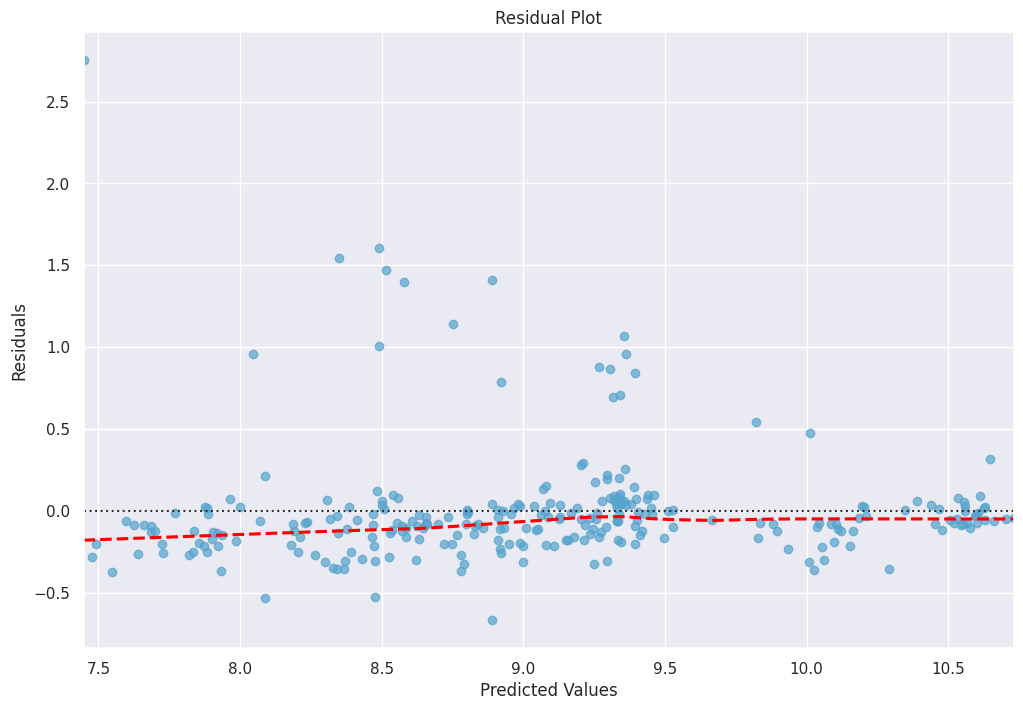

In [37]:
# Now I want to take a look at the residuals
residuals = y_test - y_pred_rfr

plt.figure(figsize = (12, 8))
sns.residplot(x = y_pred_rfr, y = residuals, scatter_kws = {'alpha': 0.7, 'color': palette}, lowess = True, line_kws = {'color': 'red', 'linestyle': '--'})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

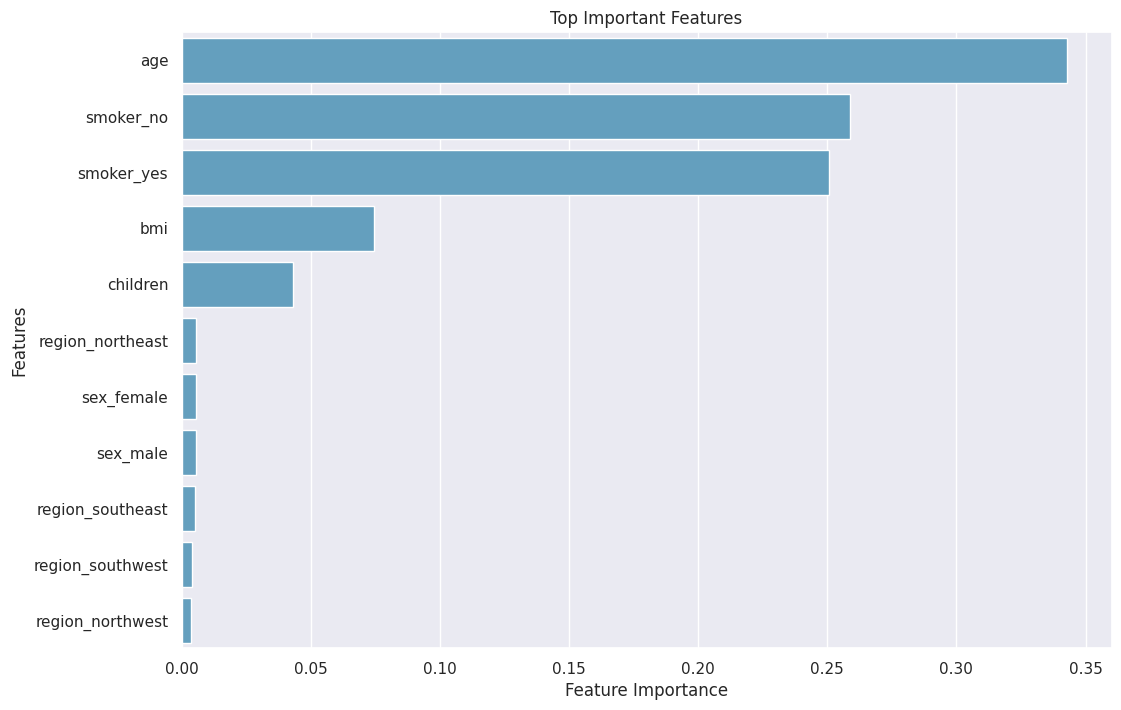

In [38]:
# Because I want to be able to use this analysis to also answer business questions, let's figure out the most important features that affect charges

top_features = pd.Series(rand_for_reg.feature_importances_, index = X.columns).sort_values(ascending = False)

# I am assuming the 4 most important will be Age, Smoking Status, BMI, and either Sex or Location, so let's see

plt.figure(figsize = (12, 8))
sns.barplot(x = top_features, y = top_features.index, palette = palette)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top Important Features')
plt.show()

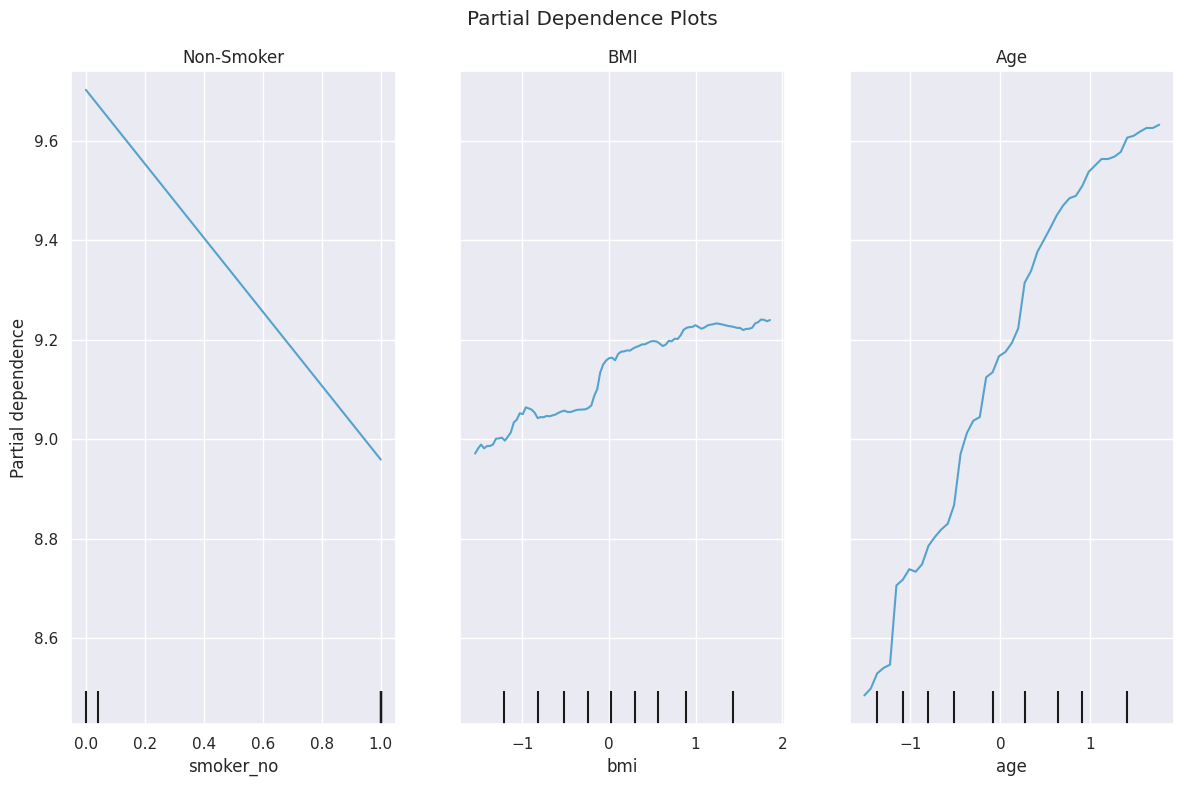

In [39]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

# I'm only a little surprised with this result, but I believe 'smoker_no' still has an interaction with bmi and age, which means it will still be important. Let's see if we can clarify that.

focus_features = ['smoker_no', 'bmi', 'age']
display = PartialDependenceDisplay.from_estimator(rand_for_reg, X_test, focus_features, kind = 'average')

display.figure_.suptitle('Partial Dependence Plots')
display.figure_.set_size_inches(12, 8)
display.axes_[0, 0].set_title('Non-Smoker')
display.axes_[0, 1].set_title('BMI')
display.axes_[0, 2].set_title('Age')
display.figure_.tight_layout()
plt.show()

In [40]:
# Time to save my model to use another time.
import pickle

med_insurance_rfr_pred_model = 'med_insurance_rfr_pred_model.pkl'
pickle.dump(rand_for_reg, open(med_insurance_rfr_pred_model, 'wb'))

In [41]:
# For future use if I want to load and use.
#import pickle
#prediction_model = 'med_insurance_rfr_pred_model.pkl'
#loaded_model = pickle.load(open(prediction_model, 'rb'))